In [35]:
from pettingzoo.classic import connect_four_v3

In [36]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [37]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

# state is a dictionary with two keys: observation and action_mask
print(
    state["observation"].shape
)  # Observation is a numpy array with three coordinates, indicating the positions of the pieces of player 0 and 1 on the the board
print(state["observation"][:, :, 0])  # Where the pieces of player 0 are
print(state["observation"][:, :, 1])  # Where the pieces of player 1 are

print(state["action_mask"])  # an array showing whether the actions are legal or nots


(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


In [38]:
env.reset()
env.step(0)

state, reward, terminated, truncated, info = env.last()

print(
    state["observation"].shape
) 
print(state["observation"][:, :, 0])  
print(state["observation"][:, :, 1])  

print(state["action_mask"])


(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [39]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_action(self, obs_mask, epsilon=None):
        return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())


In [40]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_action(self, obs_mask, epsilon=None):
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                return i
        return None


# Running a game


The following function runs a full game between the two agents. 

In [283]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                    print(obs['action_mask'])
                    print("Player_0 reward: ", env.rewards['player_0'])
                    print("Player_1 reward: ", env.rewards['player_1'])
                return i

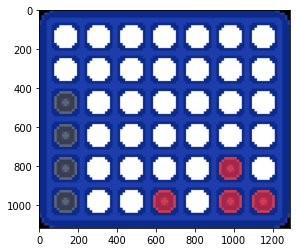

Player 1: Q Learning Agent Fix won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0 -1  0]
 [ 1  0  0 -1  0 -1 -1]]


1

In [26]:
agent0 = RandomPlayer()
agent1 = QLearningAgentFix()

play_game(env, agent0, agent1, display=True)

[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] conta

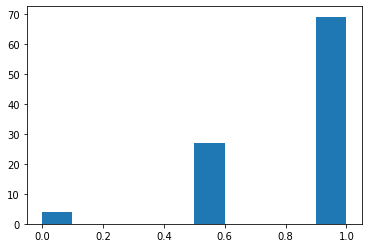

In [24]:
plt.hist([play_game(env, agent0, agent1, display=False) for _ in range(100)])
plt.show()

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [18]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [19]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

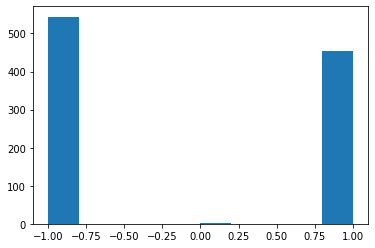

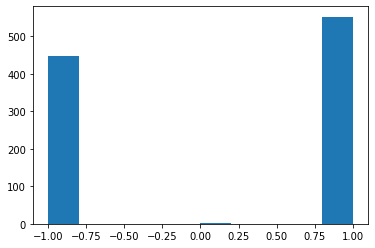

In [20]:
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
plt.show()

[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] conta

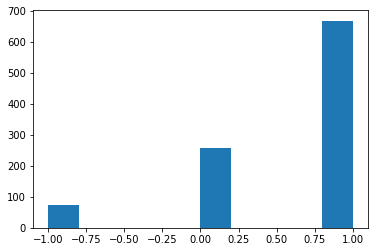

In [56]:
plt.hist(eval_against_policy(env, QLearningAgent(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()

# Q-learning Agent 



In [288]:
from collections import defaultdict

class QLearner(): 
    """
        Stores the data and computes the observed returns.
    """
    def __init__(self, 
                 gamma=0.9999, 
                 lr=0.1,
                 eps_init=.5, 
                 eps_min=1e-5,
                 eps_step=1-3,
                 name='Q-learning'):
        self.gamma = gamma
        self.lr = lr
        
        self.eps = eps_init
        self.eps_min = eps_min
        self.eps_step = eps_step

        self.name = name
        self.q_table = defaultdict(lambda: np.zeros(7))        
    
    def eps_greedy(self, obs, eps=None):
        if eps is None: 
            eps = self.eps
        action_mask = obs['action_mask']
        possible_action = list(np.where(action_mask ==1)[0])
        if np.random.random() < self.eps:
            try:
                action = random.choice(possible_action)
            except:
                action = None
            return action
        else:
            b = self.q_table[str(obs)]
            return np.random.choice(np.flatnonzero(b == np.max(b))) # argmax with random tie-breaking
            #return np.argmax(b)
        
    def get_action(self, obs, epsilon=None):
        return self.eps_greedy(obs)
        
    def update(self, obs, action, reward, terminated, next_obs):
        # update the q-values
        estimate_value_at_next_state = (not terminated) * np.max(self.q_table[str(next_obs)])
        new_estimate = reward + self.gamma * estimate_value_at_next_state
        
        self.q_table[str(obs)][action] = (
            (1 - self.lr) * self.q_table[str(obs)][action] 
            + self.lr * new_estimate
        )
        
        self.epsilon_decay()
        
    def epsilon_decay(self):
        self.eps = max(self.eps - self.eps_step, self.eps_min)
        
    def train(self, num_episodes):
        """
        Trains the agent using Q-learning, against a random opponent
        """
        rewards = []
        random_agent = PlayLeftmostLegal()
        for i in range(num_episodes):
            done = False
            env.reset()
            observation, reward, termination, truncation, info = env.last()
            while not done:
                if termination or truncation:
                    done = True
                    break
                observation, _, termination, truncation, info = env.last()
                action = self.get_action(observation)
                if not(termination or truncation):
                    env.step(action)
                next_observation, _, termination, truncation, info = env.last()
                reward = env.rewards['player_0']
                self.update(observation, action, reward, termination, next_observation)
                observation = next_observation

                # opponent's turn
                action = random_agent.get_action(observation)
                if not(termination or truncation):
                    env.step(action)
                next_observation, _, termination, truncation, info = env.last()
                # reward = env.rewards['player_1']
                # random_agent.update(observation, action, reward, termination, next_observation)
                observation = next_observation
            rewards.append(reward)
        return rewards
                

In [258]:
import random

class QLearningAgent:
    def __init__(self, alpha=0.5, epsilon=0.1, gamma=0.99):
        self.name = "Q-Learning Agent"
        self.q_table = {}
        self.alpha = alpha # learning rate
        self.epsilon = epsilon # exploration rate
        self.gamma = gamma # discount rate
        self.rng = np.random.default_rng() # random number generator

    def get_action(self, obs_mask, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon
        if random.random() < epsilon:
            return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])
        else:
            return self.best_choice_with_mask(np.arange(7), obs_mask["action_mask"], obs_mask["observation"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())
    
    def best_choice_with_mask(self, arr, mask, obs):
        """
        Selects the action with the highest Q-value
        """
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        q_values = [self.q_table.get((tuple(obs.flatten()), action), 0) for action in masked_arr.compressed()]
        max_q = max(q_values)
        choice = np.random.choice([action for action, q in zip(masked_arr.compressed(), q_values) if q == max_q])
        return choice

    def train(self, num_episodes):
        """
        Trains the agent using Q-learning, against a random opponent
        """
        rewards = []
        random_agent = PlayLeftmostLegal()
        for i in range(num_episodes):
            done = False
            env.reset()
            obs, _, _, _, _ = env.last()
            while not done:
                action = self.get_action(obs)
                env.step(action)
                obs, reward, terminated, _, _ = env.last()
                done = terminated
                if np.sum(obs["action_mask"]) == 0:
                    reward = 0.5
                    done = True
                if done:
                    self.q_table[(tuple(obs["observation"].flatten()), action)] = reward
                    break
                else:
                    next_action = self.get_action(obs)
                    self.q_table[(tuple(obs["observation"].flatten()), action)] = reward + self.gamma * self.q_table.get((tuple(obs["observation"].flatten()), next_action), 0)
                                
                # Opponent's turn
                action = random_agent.get_action(obs)
                env.step(action)
                obs, reward, terminated, _, _ = env.last()
                done = terminated
                if np.sum(obs["action_mask"]) == 0:
                    reward = 0.5
                    done = True
                if done:
                    self.q_table[(tuple(obs["observation"].flatten()), action)] = reward
                    break
                else:
                    next_action = self.get_action(obs)
                    self.q_table[(tuple(obs["observation"].flatten()), action)] = reward + self.gamma * self.q_table.get((tuple(obs["observation"].flatten()), next_action), 0)
            rewards.append(reward)
        return rewards



In [261]:
agent = QLearningAgent()
rewards = agent.train(num_episodes=1000)

In [289]:
q_agent = QLearner()
rewards = q_agent.train(num_episodes=100)

In [290]:
rewards

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

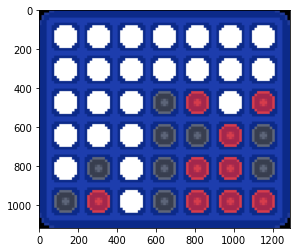

Player 1: Random Player won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  1 -1  0 -1]
 [ 0  0  0  1  1 -1  1]
 [ 0  1  0  1 -1 -1  1]
 [ 1 -1  0  1 -1 -1 -1]]
[1 1 1 1 1 1 1]


1

In [262]:
play_game(env, q_agent, RandomPlayer(), display=True)

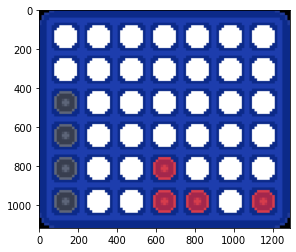

Player 1: Left Player won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0 -1  0  0  0]
 [ 1  0  0 -1 -1  0 -1]]
[1 1 1 1 1 1 1]
Player_0 reward:  -1
Player_1 reward:  1


1

In [291]:
play_game(env, q_agent, PlayLeftmostLegal(), display=True)